# Цель работы

**Цель** - определить, улучшает ли новый алгоритм рекомендаций постов ключевую метрику (CTR).

**Идея** - взять две группы (2-ая экспериментальная, 1-ая контрольная) и с помощью А/В тестов, а также графиков, определить есть ли разница в группах по ключевой метрике, и если есть, то определить, где она лучше, а где хуже.

**Задачи**:

1. Проводим А/А тест, чтобы убедиться, что группы до нововведения были примерно одинаковыми (по показателям ключевой метрики).
2. Изучаем данные (особенно поведение ключевой метрики) и выбираем метод анализа для А/В теста.
3. Верифицируем наши выводы и делаем заключение.
3. Попробуем придумать гипотезы для полученных выводов (потенциальные ситуации, когда такое изменение могло произойти).
4. Даём рекомендацию - стоит ли раскатывать новый алгоритм на всех пользователей.

# Анализ

## Подготовка к анализу

In [1]:
# Загружаем библиотеки

import pandahouse
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Соединияемся с сервером из ClickHouse

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230320'
}

In [3]:
# Выбираем данные

q = """
    SELECT 
            exp_group,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes / views as CTR
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-03-02' and '2023-03-08'
            and exp_group in (1, 2)
    GROUP BY exp_group, user_id
    
"""

q_aa = """
    SELECT 
            exp_group,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes / views as CTR
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-02-22' and '2023-02-28'
            and exp_group in (1, 2)
    GROUP BY exp_group, user_id
    
"""

In [4]:
# Создаем датафрейм

df = pandahouse.read_clickhouse(q, connection=connection)
df_aa = pandahouse.read_clickhouse(q_aa, connection=connection)

In [5]:
# Настраиваем размер графиков

sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [6]:
# Создаем подвыборки с эксперементальными группами

g_treatment = df[df.exp_group == 2] # группа с новым алгоритмом
g_control = df[df.exp_group == 1] # группа без изменений

## Первичный анализ данных

#### AA тест (неделя до эксперимента)

In [20]:
# Проверяем, что группы статистически эквивалентны

df_aa.groupby('exp_group').count()

,user_id,likes,views,CTR
exp_group,,,,
1,8423,8423,8423,8423
2,8342,8342,8342,8342


**Вывод**: количесто наблюдений примерно одинаковое => можем считать, что они статистически эквивалентны

Text(0, 0.5, 'Кол-во')

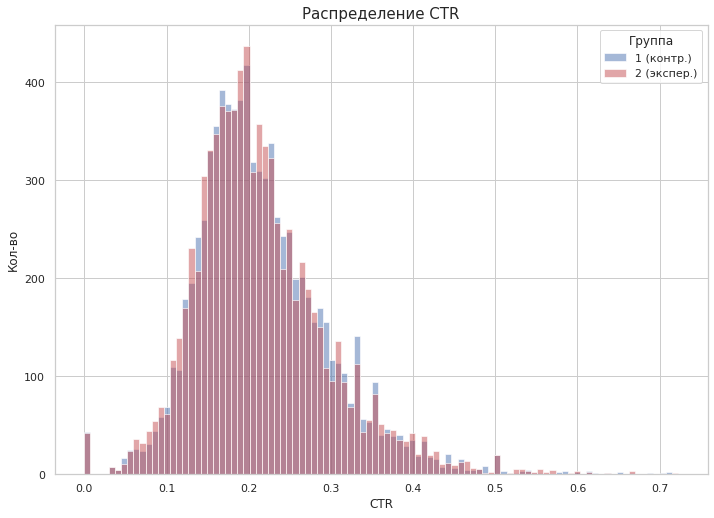

In [37]:
# Смотрим на распределение ключевой метрики (CTR) в каждой группе

sns.set_style("whitegrid")
groups = sns.histplot(data=df_aa,
                     x='CTR',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False,
                     legend=False)

# Добавляем подписи 

plt.legend(title='Группа', loc='upper right', labels=['1 (контр.)','2 (экспер.)'])
plt.title('Распределение CTR', fontsize=15)
plt.xlabel('CTR')
plt.ylabel('Кол-во')

**Вывод**: в целом группы одинаковы и можно проводить анализ. Более того, распределение похоже на нормальное, значит можно использовать ttest.

In [38]:
# Проверяем наблюдения на тестах

ttest = stats.ttest_ind(df_aa[df_aa.exp_group == 1].CTR, df_aa[df_aa.exp_group == 2].CTR)
print(f'Значение p-value (ttest): {ttest[1]}')

# Для верификации проведем доп. тест Манна-Уитни 

mann_whit = stats.mannwhitneyu(df_aa[df_aa.exp_group == 1].CTR, df_aa[df_aa.exp_group == 2].CTR)
print(f'Значение p-value (mann_whit): {mann_whit[1]}')

Значение p-value (ttest): 0.16371860578902486
Значение p-value (mann_whit): 0.06197086609272732


**Вывод**: p-value больше 0.05 => группы примерно одинаковые до проведения эксперимента

#### Данные во время эксперимента

Text(0, 0.5, 'Кол-во')

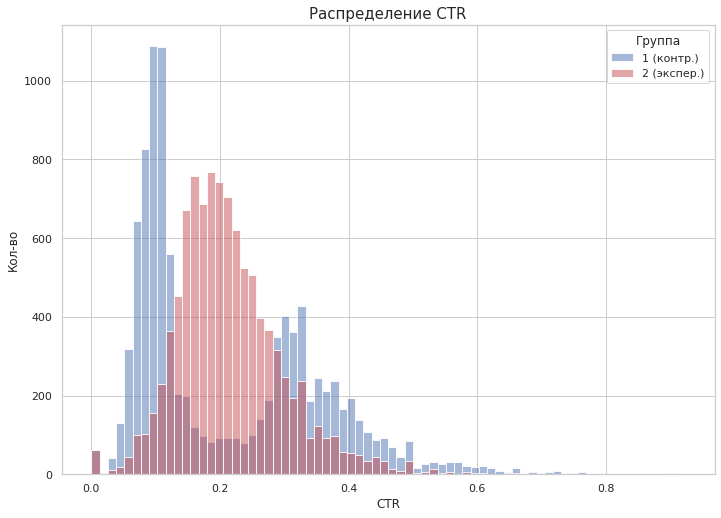

In [44]:
# Смотрим на распределение ключевой метрики (CTR) в каждой группе

sns.set_style("whitegrid")
groups = sns.histplot(data=df,
                     x='CTR',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False,
                     legend=False)

# Добавляем подписи 

plt.legend(title='Группа', loc='upper right', labels=['1 (контр.)','2 (экспер.)'])
plt.title('Распределение CTR', fontsize=15)
plt.xlabel('CTR')
plt.ylabel('Кол-во')

**Вывод**: есть различия между распределением => есть эффект от воздействия (релевантно использовать тесты)

## Анализ - А/В тест

Построим гистограммы отдельно для каждой группы, чтобы посмотреть на их распределение более внимательно

Text(0, 0.5, 'Кол-во')

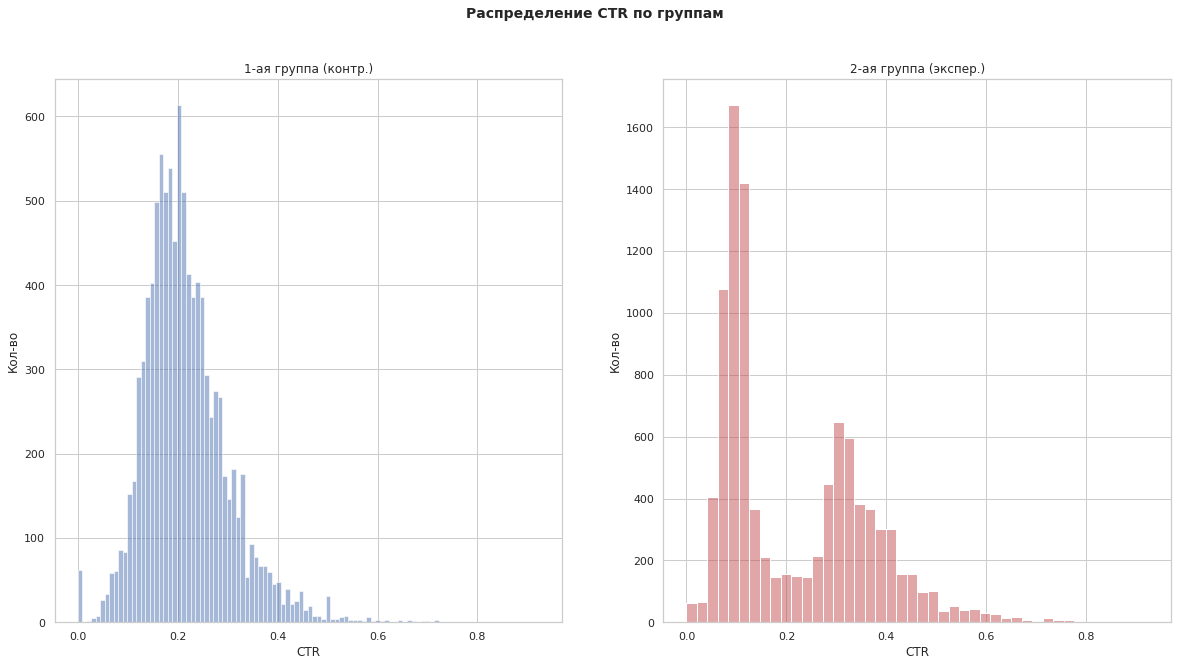

In [12]:
# Создаем настройки для объединения графиков
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
fig.suptitle(f'Распределение CTR по группам', fontweight='bold',fontsize=14)
# Задаем позиции
ax_1 = ax[0]
ax_2 = ax[1]

# Для контрольной группы
sns.histplot(data=df[df.exp_group == 1].CTR, color='b' ,alpha=0.5, ax=ax_1 )
# Добавляем подписи
ax_1.set_title(f'1-ая группа (контр.)', fontsize=12)
ax_1.set_xlabel('CTR')
ax_1.set_ylabel('Кол-во')

# Для экспериментальной группы
sns.histplot(data=df[df.exp_group == 2].CTR, color='r' ,alpha=0.5, ax=ax_2)
# Добавляем подписи 
ax_2.set_title(f'2-ая группа (экспер.)', fontsize=12)
ax_2.set_xlabel('CTR')
ax_2.set_ylabel('Кол-во')

**Выводы**
1. Группа 1 имеет +- нормальное распределение;
2. Группа 2 имеет двугорбчатое распределение => трудно назвать нормальным

Поэтому использование ttest будет неуместно (нарушается допущение), можно использовать **тест Манна-Уитни** 

In [43]:
# Проводим тест Манна-Уитни

mann_whit = stats.mannwhitneyu(g_treatment.CTR, g_control.CTR)
mann_whit

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

**Вывод**: значение **p-value меньше даже 1%** => эффект от нашего нового алгоритма есть. 
Однако нельзя пока утверждать направленность этого эффекта - ухудшил ли он положение вещей или улучшил.

## Верификация результата

Для того, чтобы убедиться, что мы не ошиблись (а также узнать направленность нашего эффекта), проверим на другом тесте нашу гипотезу. Например, нам также подойдет **Пуассоновский бутстреп**

In [28]:
# Создаем функцию для подсчета бутстрепа

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2_000):
    poisson_boot_1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_boot_2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    global_ctr_1 = (poisson_boot_1 * likes1).sum(axis=1) / (poisson_boot_1 * views1).sum(axis=1)
    global_ctr_2 = (poisson_boot_2 * likes2).sum(axis=1) / (poisson_boot_2 * views2).sum(axis=1)
    
    return global_ctr_1, global_ctr_2

In [29]:
# Определяем переменные под лайки и просмотры в каждой группе

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [30]:
# Считаем общий CTR по группам после бутстрапа

ctr_1, ctr_2 = bootstrap(likes1, views1, likes2, views2)

Text(0, 0.5, 'Кол-во')

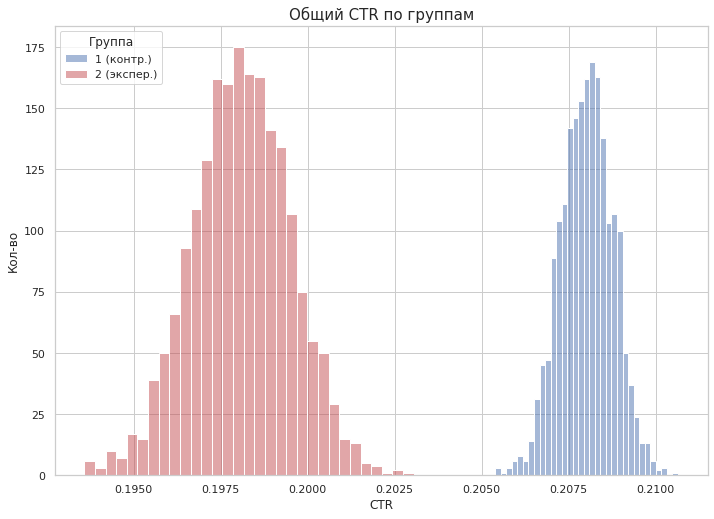

In [31]:
# Рисуем гистограмму получившегося CTR

sns.set_style("whitegrid")
sns.histplot(ctr_1, color='b', alpha=0.5)
sns.histplot(ctr_2, color='r', alpha=0.5)

# Добавляем подписи 

plt.legend(title='Группа', loc='upper left', labels=['1 (контр.)','2 (экспер.)'])
plt.title('Общий СTR по группам', fontsize=15)
plt.xlabel('CTR')
plt.ylabel('Кол-во')

Text(0.5, 0, 'СTR')

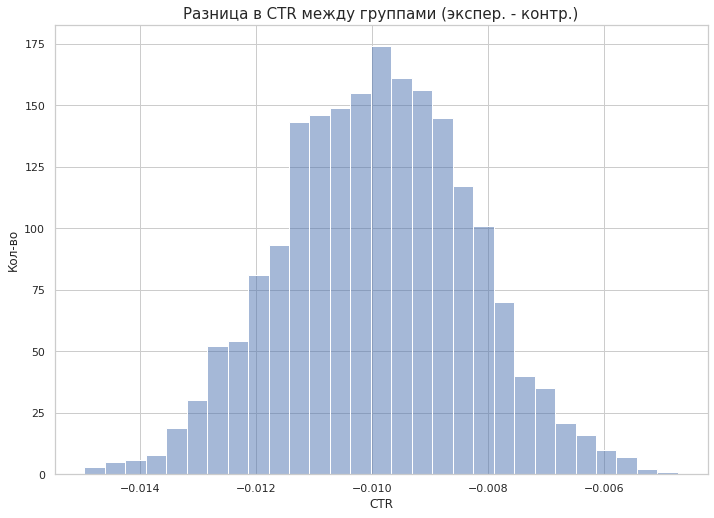

In [32]:
# Посмотрим на разницу в получившихся CTR

sns.set_style("whitegrid")
sns.histplot(ctr_2 - ctr_1, alpha=0.5)

# Добавляем подписи 

plt.title('Разница в CTR между группами (экспер. - контр.)', fontsize=15)
plt.ylabel('Кол-во')
plt.xlabel('СTR')

**Вывод**:
1. Первые графики показывают, что мы действительно наблюдаем разный CTR для групп 1 и 2;
2. Более того, мы видим, что в контрольной группе - группе 1 - общий СTR выше, чем в группе с новым алгоритмом - группе 2;
3. Пункт 2 подтверждает и последний график, на котором представлена разница двух CTR (CTR группы 2 - CTR группы 1). Эффект отрицательный.

Text(5.334999999999994, 0.5, 'Лайки')

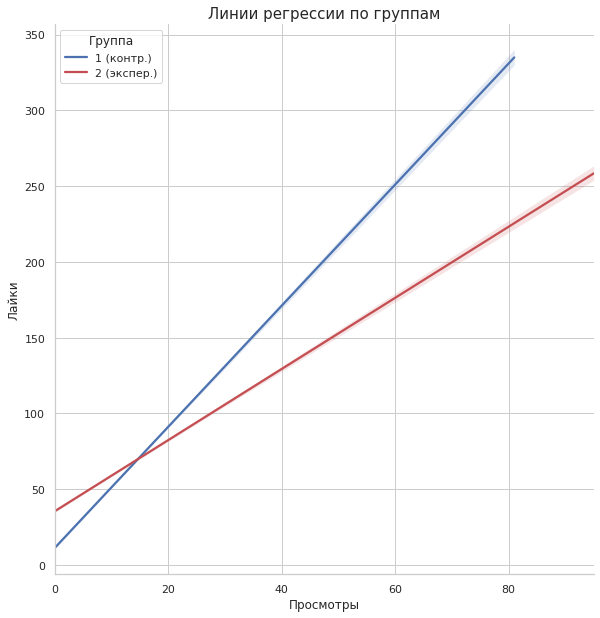

In [33]:
# Посмотрим на распределение данных еще одним способом (с линейной регрессией)

sns.set_style("whitegrid")
g_linear = sns.lmplot(x='likes',
                      y='views',
                      hue='exp_group',
                      data=df,
                      height=8.27,
                      palette=['b','r'],
                      scatter=False,
                      legend=False)

# Добавляем подписи 

plt.legend(title='Группа', loc='upper left', labels=['1 (контр.)','2 (экспер.)'])
plt.title('Линии регрессии по группам', fontsize=15)
plt.xlabel('Просмотры')
plt.ylabel('Лайки')

**Вывод**: данный график показывает регрессионные линии для двух групп. Мы можем четко отметить, что линия тренда первой группы выше, чем у второй. Что подтверждает наши выводы

## Выводы

Главный вывод в том, что алгоритм показывает меньший уроень CTR, по сравнению с группой со старой схемой предложения рекомендаций. Однако распределение ключевой метрики оказалось двуборчатым, поэтому однозначно сказать, что алгоритм в целом плох - нельзя. Нужно более детальное изучение (возможно по каким-то группам).

**Когда такая ситуация могла произойти?**
1. Возможно разработчики не верно определили признаки конвертации просмотров в лайки. Например, они ориентировались по лайками пользователя, и рекомендовали ему посты по схожей тематике, а лучше было бы ориентирвоаться на общих предпочтениях с другими пользователями, оценивших несколько постов с нашим пользователем.
2. Возможно проблема в самом эксперименте - например, слишком короткий (всего неделю). Плюс он может выпадать на какие-нибудь каникулы или праздники, когда люди могут больше сидеть в соц. сетях (поведение будет не типичным). А если это каникулы - то возможно больше в сети детей и подростков, которые гипотетически могут быть больше склонны ставить лайки (тогда нужно еще и знать примерно возростную группу пользователей).